In [82]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math

In [100]:
# Load the dataset
file_path = 'combined_df.csv'
data = pd.read_csv(file_path)

data = data[
    (data['Year'] >= 2020) &
    (data['Headliner'].str.contains('"', na=False)) &
    (~data['Support'].isna()) &
    (data['Genre'] != 'Family Entertainment')
  ]


/tmp/ipykernel_335209/4095921683.py:3: DtypeWarning: Columns (2,3,6,7,8,9,10,28) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


In [101]:

# extract date features
def extract_date_features(df):
    df['Event Date'] = pd.to_datetime(df['Event Date'])
    df['Year'] = df['Event Date'].dt.year
    df['Month'] = df['Event Date'].dt.month
    df['Day of Week'] = df['Event Date'].dt.dayofweek
    return df


In [102]:

data = extract_date_features(data)

# target var and features
target = 'Avg. Gross USD'
features = ['Number of Shows', 'Avg. Event Capacity', 'Ticket Price Min USD', 'Ticket Price Max USD', 
            'City', 'Month', 'Day of Week']


In [103]:

# cols_to_convert = [
#     'Avg. Gross USD', 'Avg. Tickets Sold', 'Avg. Event Capacity', 
#     'Ticket Price Min USD', 'Ticket Price Max USD', 'Ticket Price Avg. USD'
# ]
# for col in cols_to_convert:
#     data[col] = pd.to_numeric(data[col].str.replace('[^0-9.]', '', regex=True), errors='coerce')



Text(0, 0.5, 'Frequency')

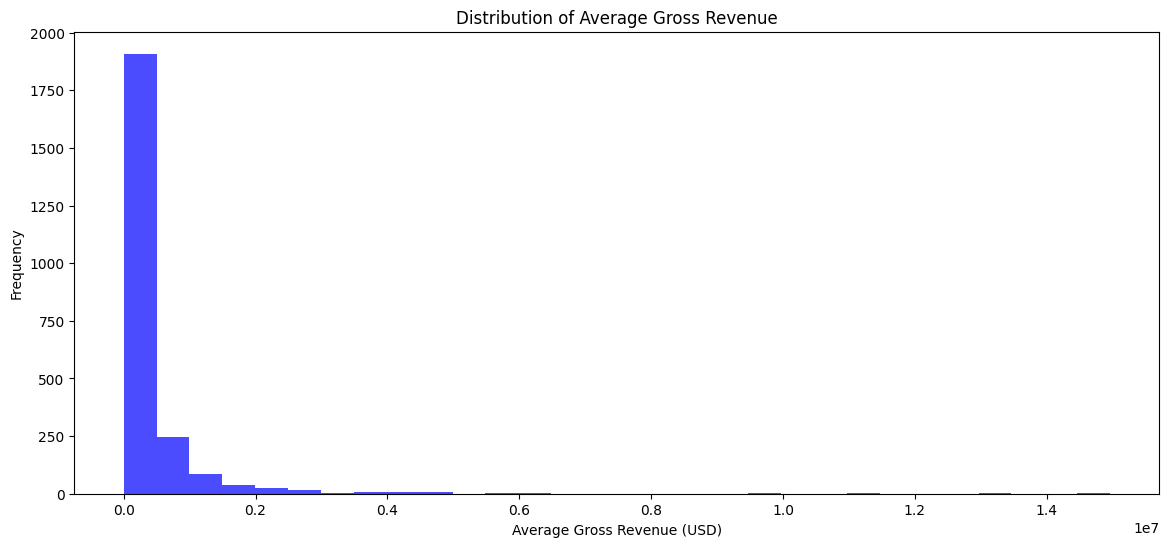

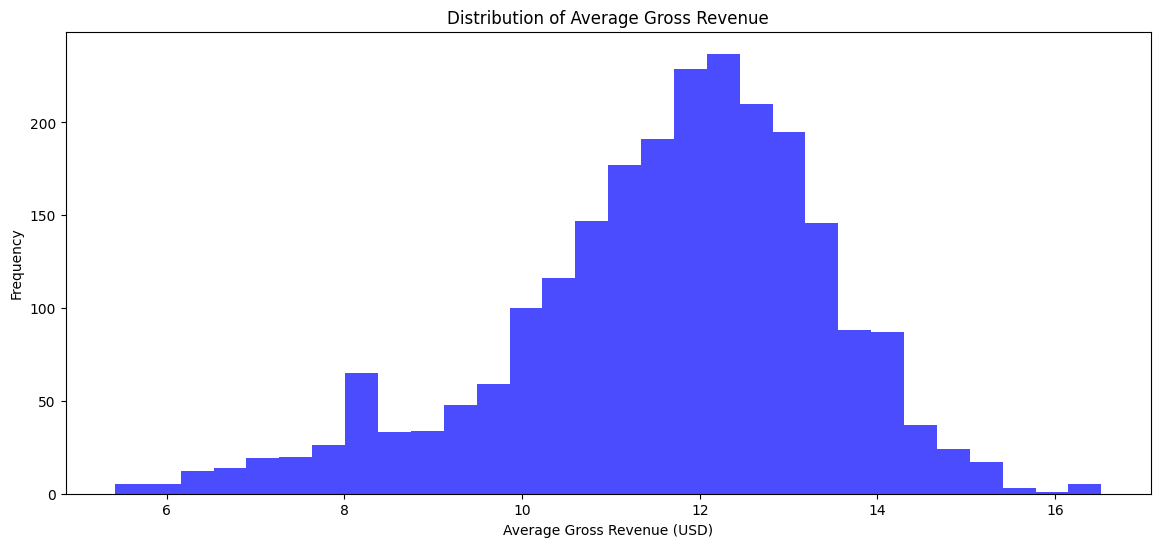

In [104]:
# Histograms for average gross revenue and log
plt.figure(figsize=(14, 6))

plt.hist(data['Avg. Gross USD'].dropna(), bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Average Gross Revenue')
plt.xlabel('Average Gross Revenue (USD)')
plt.ylabel('Frequency')

plt.figure(figsize=(14, 6))

plt.hist(np.log(data['Avg. Gross USD'].dropna()), bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Average Gross Revenue')
plt.xlabel('Average Gross Revenue (USD)')
plt.ylabel('Frequency')


In [105]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2350 entries, 100 to 109682
Data columns (total 54 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Event Date                       2350 non-null   datetime64[ns]
 1   Headliner                        2350 non-null   object        
 2   sp artist_name                   92 non-null     object        
 3   sp artist_genre                  92 non-null     object        
 4   sp followers                     92 non-null     float64       
 5   sp popularity                    92 non-null     float64       
 6   yt name                          85 non-null     object        
 7   yt Channel ID                    85 non-null     object        
 8   yt Title                         85 non-null     object        
 9   yt Description                   47 non-null     object        
 10  yt Published At                  85 non-null     object      

In [106]:
# preprocessors
numerical_features = ['Number of Shows', 'Avg. Event Capacity', 'Ticket Price Min USD', 'Ticket Price Max USD', 
                      'Month', 'Day of Week']
categorical_features = ['City']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


Models

In [107]:
# Still working on
# Pipeline for grid search among models and features
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', LinearRegression())]) 

model_params = [
    {'model': [LinearRegression()]},
    {'model': [Lasso()], 'model__alpha': [0.001, 0.01, 0.1, 1]},
    {'model': [RandomForestRegressor()], 'model__n_estimators': [50, 100, 200]},
    {'model': [XGBRegressor(objective='reg:squarederror')], 'model__max_depth': [3, 5], 'model__n_estimators': [50, 100]}
]

scoring = {
    'RMSE': make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False), greater_is_better=False),
    'R2': 'r2',
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False)
}

grid_search = GridSearchCV(pipeline, model_params, cv=5, scoring=scoring, refit='RMSE', verbose=3, return_train_score=False)

grid_search.fit(data[features], data[target])

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation RMSE score: ", -grid_search.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END model=LinearRegression(); MAE: (test=-223716.810) R2: (test=0.516) RMSE: (test=-307310.522) total time=   0.0s
[CV 2/5] END model=LinearRegression(); MAE: (test=-234827.038) R2: (test=0.652) RMSE: (test=-745860.684) total time=   0.0s
[CV 3/5] END model=LinearRegression(); MAE: (test=-269310.938) R2: (test=0.421) RMSE: (test=-567244.369) total time=   0.0s
[CV 4/5] END model=LinearRegression(); MAE: (test=-276363.273) R2: (test=0.700) RMSE: (test=-429709.829) total time=   0.0s
[CV 5/5] END model=LinearRegression(); MAE: (test=-310312.768) R2: (test=-5.352) RMSE: (test=-1831096.528) total time=   0.0s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and wi

[CV 1/5] END model=Lasso(), model__alpha=0.001; MAE: (test=-223186.109) R2: (test=0.516) RMSE: (test=-307336.527) total time=   0.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31679278336874.594, tolerance: 89140353955.3222
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=Lasso(), model__alpha=0.001; MAE: (test=-234782.716) R2: (test=0.652) RMSE: (test=-746015.064) total time=   0.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73616889818496.66, tolerance: 139028883548.47705
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=Lasso(), model__alpha=0.001; MAE: (test=-266629.930) R2: (test=0.422) RMSE: (test=-566902.970) total time=   0.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74722291947344.89, tolerance: 136261384928.38455
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=Lasso(), model__alpha=0.001; MAE: (test=-276361.920) R2: (test=0.698) RMSE: (test=-430868.752) total time=   0.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35132288697305.72, tolerance: 140154913518.3946
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 5/5] END model=Lasso(), model__alpha=0.001; MAE: (test=-303681.885) R2: (test=-5.349) RMSE: (test=-1830575.160) total time=   0.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92967940468296.56, tolerance: 155902879806.6466
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=Lasso(), model__alpha=0.01; MAE: (test=-223165.776) R2: (test=0.516) RMSE: (test=-307346.948) total time=   0.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30894063214149.734, tolerance: 89140353955.3222
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=Lasso(), model__alpha=0.01; MAE: (test=-234789.621) R2: (test=0.652) RMSE: (test=-746022.760) total time=   0.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73618064612240.66, tolerance: 139028883548.47705
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=Lasso(), model__alpha=0.01; MAE: (test=-266522.862) R2: (test=0.422) RMSE: (test=-566891.846) total time=   0.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74723234462076.61, tolerance: 136261384928.38455
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=Lasso(), model__alpha=0.01; MAE: (test=-276360.981) R2: (test=0.698) RMSE: (test=-430918.386) total time=   0.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35132910872717.75, tolerance: 140154913518.3946
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 5/5] END model=Lasso(), model__alpha=0.01; MAE: (test=-303610.091) R2: (test=-5.349) RMSE: (test=-1830567.366) total time=   0.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78643137318840.23, tolerance: 155902879806.6466
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-223011.301) R2: (test=0.516) RMSE: (test=-307479.334) total time=   0.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22875881798504.58, tolerance: 89140353955.3222
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-234844.949) R2: (test=0.652) RMSE: (test=-746092.103) total time=   0.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61528416591133.84, tolerance: 139028883548.47705
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-265550.436) R2: (test=0.422) RMSE: (test=-566805.406) total time=   0.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51410329443165.84, tolerance: 136261384928.38455
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-276352.539) R2: (test=0.698) RMSE: (test=-431298.735) total time=   0.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27255823689381.438, tolerance: 140154913518.3946
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 5/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-302971.597) R2: (test=-5.348) RMSE: (test=-1830500.479) total time=   0.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11137166916740.719, tolerance: 155902879806.6466
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=Lasso(), model__alpha=1; MAE: (test=-222957.762) R2: (test=0.513) RMSE: (test=-308337.690) total time=   0.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123908184989.78125, tolerance: 89140353955.3222
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=Lasso(), model__alpha=1; MAE: (test=-235131.651) R2: (test=0.652) RMSE: (test=-746386.703) total time=   0.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17240522067050.688, tolerance: 139028883548.47705
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=Lasso(), model__alpha=1; MAE: (test=-262116.758) R2: (test=0.422) RMSE: (test=-566675.099) total time=   0.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8064810978454.031, tolerance: 136261384928.38455
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=Lasso(), model__alpha=1; MAE: (test=-276393.379) R2: (test=0.695) RMSE: (test=-433043.302) total time=   0.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 619748376900.75, tolerance: 140154913518.3946
  model = cd_fast.sparse_enet_coordinate_descent(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 5/5] END model=Lasso(), model__alpha=1; MAE: (test=-300791.532) R2: (test=-5.345) RMSE: (test=-1830090.140) total time=   0.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-104397.356) R2: (test=0.764) RMSE: (test=-214399.507) total time=   0.7s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-160692.822) R2: (test=0.772) RMSE: (test=-603283.685) total time=   0.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-121749.076) R2: (test=0.609) RMSE: (test=-466124.303) total time=   0.7s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-168674.589) R2: (test=0.725) RMSE: (test=-411419.165) total time=   0.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 5/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-90405.172) R2: (test=0.895) RMSE: (test=-234930.210) total time=   0.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-104897.405) R2: (test=0.771) RMSE: (test=-211604.148) total time=   1.3s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-158453.227) R2: (test=0.772) RMSE: (test=-603345.368) total time=   1.3s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-121022.350) R2: (test=0.586) RMSE: (test=-479849.140) total time=   1.3s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-165074.314) R2: (test=0.754) RMSE: (test=-389345.607) total time=   1.3s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 5/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-94139.422) R2: (test=0.885) RMSE: (test=-246160.629) total time=   1.3s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-104969.609) R2: (test=0.775) RMSE: (test=-209560.895) total time=   2.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-158424.492) R2: (test=0.786) RMSE: (test=-584992.200) total time=   2.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-122393.334) R2: (test=0.578) RMSE: (test=-484130.353) total time=   2.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-160090.117) R2: (test=0.774) RMSE: (test=-372497.689) total time=   2.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 5/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-89475.581) R2: (test=0.898) RMSE: (test=-232397.492) total time=   2.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and wi

[CV 1/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=3, model__n_estimators=50; MAE: (test=-116069.376) R2: (test=0.765) RMSE: (test=-213979.582) total time=   0.4s
[CV 2/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_by

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and wi

[CV 5/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=3, model__n_estimators=50; MAE: (test=-176774.910) R2: (test=0.393) RMSE: (test=-566220.101) total time=   0.2s
[CV 1/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_by

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and wi

[CV 3/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=5, model__n_estimators=50; MAE: (test=-124224.955) R2: (test=0.799) RMSE: (test=-333833.694) total time=   0.0s
[CV 4/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_by

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=5, model__n_estimators=100; MAE: (test=-141182.483) R2: (test=0.871) RMSE: (test=-454389.736) total time=   0.0s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=5, model__n_estimators=100; MAE: (test=-123315.516) R2: (test=0.803) RMSE: (test=-330438.211) total time=   0.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=5, model__n_estimators=100; MAE: (test=-143314.897) R2: (test=0.770) RMSE: (test=-376266.895) total time=   0.3s
[CV 5/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_b

In [108]:

results = grid_search.cv_results_
for mean_rmse, mean_r2, mean_mae, params in zip(results['mean_test_RMSE'], results['mean_test_R2'], results['mean_test_MAE'], results['params']):
    print(f"Params: {params} - RMSE: {-mean_rmse}, R^2: {mean_r2}, MAE: {-mean_mae}")

Params: {'model': LinearRegression()} - RMSE: 776244.3864732274, R^2: -0.6126663276164026, MAE: 262906.16518926277
Params: {'model': Lasso(), 'model__alpha': 0.001} - RMSE: 776339.6945957582, R^2: -0.6121729374018017, MAE: 260928.5120388615
Params: {'model': Lasso(), 'model__alpha': 0.01} - RMSE: 776349.4611904875, R^2: -0.612179489099578, MAE: 260889.866254012
Params: {'model': Lasso(), 'model__alpha': 0.1} - RMSE: 776435.2114019999, R^2: -0.6122543684954533, MAE: 260546.164570406
Params: {'model': Lasso(), 'model__alpha': 1} - RMSE: 776906.5870207277, R^2: -0.6127188196589373, MAE: 259478.21646163822
Params: {'model': RandomForestRegressor(), 'model__n_estimators': 50} - RMSE: 386031.3740253296, R^2: 0.7532386368972868, MAE: 129183.80285718723
Params: {'model': RandomForestRegressor(), 'model__n_estimators': 100} - RMSE: 386060.9785267868, R^2: 0.7534742824578737, MAE: 128717.34357150183
Params: {'model': RandomForestRegressor(), 'model__n_estimators': 200} - RMSE: 376715.7256038939,

In [109]:
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', LinearRegression())]) 

model_params = [
    {'model': [LinearRegression()]},
    {'model': [Lasso()], 'model__alpha': [0.001, 0.01, 0.1, 1]},
    {'model': [RandomForestRegressor()], 'model__n_estimators': [50, 100, 200]},
    {'model': [XGBRegressor(objective='reg:squarederror')], 'model__max_depth': [3, 5], 'model__n_estimators': [50, 100]}
]

scoring = {
    'RMSE': make_scorer(lambda y_true, y_pred: mean_squared_error(np.exp(y_true)-1, np.exp(y_pred)-1, squared=False), greater_is_better=False),
    'R2': 'r2',
    'MAE': make_scorer(lambda y_true, y_pred:mean_absolute_error(np.exp(y_true)-1, np.exp(y_pred)-1), greater_is_better=False)
}

grid_search = GridSearchCV(pipeline, model_params, cv=5, scoring=scoring, refit='RMSE', verbose=3, return_train_score=False)

grid_search.fit(data[features], np.log(data[target]+1))

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation RMSE score: ", -grid_search.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END model=LinearRegression(); MAE: (test=-190266.429) R2: (test=0.545) RMSE: (test=-403728.521) total time=   0.0s
[CV 2/5] END model=LinearRegression(); MAE: (test=-9895603.747) R2: (test=0.629) RMSE: (test=-122634988.203) total time=   0.0s
[CV 3/5] END model=LinearRegression(); MAE: (test=-11207997.393) R2: (test=0.512) RMSE: (test=-149978945.756) total time=   0.0s
[CV 4/5] END model=LinearRegression(); MAE: (test=-496451394.828) R2: (test=0.276) RMSE: (test=-7623538072.466) total time=   0.0s
[CV 5/5] END model=LinearRegression(); MAE: (test=-468122084601950482989056.000) R2: (test=-0.899) RMSE: (test=-10148644957001676914425856.000) total time=   0.0s
[CV 1/5] END model=Lasso(), model__alpha=0.001; MAE: (test=-201075.886) R2: (test=0.545) RMSE: (test=-495600.936) total time=   0.0s
[CV 2/5] END model=Lasso(), model__alpha=0.001; MAE: (test=-10640759.376) R2: (test=0.630) RMSE: (test=-134059071.856) total time= 

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and wi

[CV 1/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-251614.820) R2: (test=0.440) RMSE: (test=-978357.453) total time=   0.0s
[CV 2/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-7270893.807) R2: (test=0.460) RMSE: (test=-88418594.910) total time=   0.0s
[CV 3/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-29107065.770) R2: (test=0.391) RMSE: (test=-430091398.142) total time=   0.0s
[CV 4/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-1611088748.136) R2: (test=0.325) RMSE: (test=-25126086515.463) total time=   0.0s
[CV 5/5] END model=Lasso(), model__alpha=0.1; MAE: (test=-15606674015986284299812864.000) R2: (test=-1.241) RMSE: (test=-338344630082099641350881280.000) total time=   0.0s
[CV 1/5] END model=Lasso(), model__alpha=1; MAE: (test=-264425.980) R2: (test=0.063) RMSE: (test=-487959.118) total time=   0.0s
[CV 2/5] END model=Lasso(), model__alpha=1; MAE: (test=-427695.808) R2: (test=0.086) RMSE: (test=-1297958.533) total time=   0.0s
[CV 3/5] END model=Lasso(),

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and wi

[CV 1/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-109480.383) R2: (test=0.910) RMSE: (test=-220472.371) total time=   0.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-166547.737) R2: (test=0.914) RMSE: (test=-676680.365) total time=   0.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-108785.680) R2: (test=0.909) RMSE: (test=-367045.922) total time=   0.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-156494.806) R2: (test=0.876) RMSE: (test=-389803.057) total time=   0.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 5/5] END model=RandomForestRegressor(), model__n_estimators=50; MAE: (test=-105143.740) R2: (test=0.920) RMSE: (test=-323211.029) total time=   0.6s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-107903.455) R2: (test=0.912) RMSE: (test=-211238.185) total time=   1.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-165197.614) R2: (test=0.914) RMSE: (test=-686247.363) total time=   1.3s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-105754.261) R2: (test=0.909) RMSE: (test=-350441.292) total time=   1.3s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-147150.107) R2: (test=0.875) RMSE: (test=-325095.078) total time=   1.3s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 5/5] END model=RandomForestRegressor(), model__n_estimators=100; MAE: (test=-111987.745) R2: (test=0.925) RMSE: (test=-339724.599) total time=   1.2s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-109041.390) R2: (test=0.910) RMSE: (test=-217813.027) total time=   2.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-160284.054) R2: (test=0.915) RMSE: (test=-665966.186) total time=   2.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-105491.687) R2: (test=0.911) RMSE: (test=-352318.695) total time=   2.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 4/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-147184.546) R2: (test=0.876) RMSE: (test=-331913.744) total time=   2.5s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and wi

[CV 5/5] END model=RandomForestRegressor(), model__n_estimators=200; MAE: (test=-112030.744) R2: (test=0.923) RMSE: (test=-344446.712) total time=   2.5s
[CV 1/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=3, model__n_estimators=50; MAE: (test=-108959.489) R2: (test=0

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and wi

[CV 1/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=3, model__n_estimators=100; MAE: (test=-107741.824) R2: (test=0.909) RMSE: (test=-223156.916) total time=   0.0s
[CV 2/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_b

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and wi

[CV 5/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=3, model__n_estimators=100; MAE: (test=-153075.972) R2: (test=0.908) RMSE: (test=-548145.647) total time=   0.0s
[CV 1/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_b

/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 1/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=5, model__n_estimators=100; MAE: (test=-106326.607) R2: (test=0.910) RMSE: (test=-219401.518) total time=   0.1s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 2/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=5, model__n_estimators=100; MAE: (test=-177374.601) R2: (test=0.914) RMSE: (test=-718477.835) total time=   4.7s


/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/root/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV 3/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), model__max_depth=5, model__n_estimators=100; MAE: (test=-115437.299) R2: (test=0.904) RMSE: (test=-391338.853) total time=   0.2s
[CV 4/5] END model=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_b

In [110]:

results = grid_search.cv_results_
for mean_rmse, mean_r2, mean_mae, params in zip(results['mean_test_RMSE'], results['mean_test_R2'], results['mean_test_MAE'], results['params']):
    print(f"Params: {params} - RMSE: {-mean_rmse}, R^2: {mean_r2}, MAE: {-mean_mae}")

Params: {'model': LinearRegression()} - RMSE: 2.0297289914003372e+24, R^2: 0.21265135002000085, MAE: 9.362441692039021e+22
Params: {'model': Lasso(), 'model__alpha': 0.001} - RMSE: 4.743189296556274e+24, R^2: 0.20285582315682477, MAE: 2.187870075830869e+23
Params: {'model': Lasso(), 'model__alpha': 0.01} - RMSE: 5.812247422573404e+26, R^2: 0.10219805313337149, MAE: 2.680989818054708e+25
Params: {'model': Lasso(), 'model__alpha': 0.1} - RMSE: 6.766892601641993e+25, R^2: 0.07499679638155392, MAE: 3.121334803197257e+24
Params: {'model': Lasso(), 'model__alpha': 1} - RMSE: 813096.9875069906, R^2: 0.07429923554370292, MAE: 314193.9688901492
Params: {'model': RandomForestRegressor(), 'model__n_estimators': 50} - RMSE: 395442.54869795486, R^2: 0.9055950181251301, MAE: 129290.4692906457
Params: {'model': RandomForestRegressor(), 'model__n_estimators': 100} - RMSE: 382549.303558305, R^2: 0.9067534776254383, MAE: 127598.63617761647
Params: {'model': RandomForestRegressor(), 'model__n_estimators'